# Determine Food Item's Unhealthfulness Score 
# using FSANZ Nutrient Profilling System
# with XGBoost ML algotithm (regression task)

<img src="./f.png" alt="alt text" style="height: 300px">

https://www.foodstandards.gov.au/business/labelling/nutrition-health-and-related-claims/nutrient-profiling-scoring-criterion



# import packages

In [3]:
### Load packages
import numpy as np
import pandas as pd
import os
import re
import random
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import statistics 

# set random
seed = 1234
random.seed = 1234
random.seed = 1234
np.random.seed(seed)

import sys
def is_64bit() -> bool:
    return sys.maxsize > 2**32
is_64bit()

True

In [ ]:
### Load t-SNE packages
from sklearn.manifold import TSNE

### Load xgboost packages
# !pip install xgboost
import xgboost

### Load prediction packages
from sklearn import metrics, preprocessing, linear_model, svm, gaussian_process, neighbors
from sklearn.metrics import roc_auc_score,mean_squared_error,r2_score,accuracy_score,balanced_accuracy_score,roc_curve,auc,f1_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
# classification
from xgboost.sklearn import XGBClassifier #XGBoost Classifier
# regression
from xgboost.sklearn import XGBRegressor #XGBoost

# import OpenFoodFact Data

In [5]:
dfOFF = pd.read_csv("/Users/hgl/Dropbox/545_Group_Project/545_Group_project_shared/food_fact.csv",header=0)

dfOFF['KCAL'] = dfOFF['energy']/4.18
dfOFF['NAsodium'] = dfOFF['sodium']*1000
dfOFF.columns
dfOFF

/var/folders/6l/n964dwrj0ys303n336mlx0k40000gn/T/ipykernel_54473/2275255943.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  dfOFF = pd.read_csv("/Users/hgl/Dropbox/545_Group_Project/545_Group_project_shared/food_fact.csv",header=0)


,Unnamed: 0,code,product_name,brands,country,ingredients_text,additives,nutrition_grade_fr,energy,fat,...,sugars,fiber,proteins,salt,sodium,nutrition-score-fr,serving_size_numeric,serving_size_units,KCAL,NAsodium
0,67,32117,Tricolor Tortellini,Napoleon,United States,"Egg pasta (refined durum semolina wheat flour,...",0.0,c,1611.0,9.23,...,1.54,3.1,13.85,1.13284,0.446000,7.0,65.0,g,385.406699,446.000000
1,72,33060,10-Grain Pancake Mix,Bob's Red Mill,United States,"Wheat, rye, triticale, oat, corn, barley, soy ...",2.0,c,1297.0,1.72,...,5.17,6.9,13.79,2.75844,1.086000,9.0,58.0,g,310.287081,1086.000000
2,175,69601,Fresh Organic Carrots,Bunny-Luv,United States,Fresh organic carrots,0.0,a,159.0,0.00,...,6.41,2.6,1.28,0.19558,0.077000,-2.0,78.0,g,38.038278,77.000000
3,176,290616,Salade Cesar,Kirkland Signature,Canada,INGREDIENTS : LAITUE. VINAIGRETTE (HUILE DE CA...,0.0,c,1210.0,12.00,...,0.00,2.0,22.00,2.16000,0.850000,6.0,100.0,g,289.473684,850.000000
4,182,1938067,Chaussons tressés aux pommes,Kirkland Signature,Canada,"Ingrédients : Pâte (farine, margarines d'huile...",5.0,c,1090.0,10.70,...,24.70,2.0,3.33,0.64700,0.255000,9.0,150.0,g,260.765550,255.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105180,355883,95656335,Chipotle Peppers In Adobo Sauce,La Costena,United States,"Chipotle peppers, water, vinegar, tomatoes, on...",0.0,c,280.0,0.00,...,6.67,10.0,0.00,3.21818,1.267000,6.0,30.0,g,66.985646,1267.000000
105181,355884,95659305,Dal Makhani,Truly Indian,United States,"Tomato, black gram, water, milk cream, cottons...",0.0,b,502.0,5.33,...,0.00,2.0,4.67,1.37160,0.540000,2.0,150.0,g,120.095694,540.000000
105182,355888,9577283844672,100% Pur Jus 4 agrumes,Cora,France,"Jus d'orange (dont pulpe 1,6%), jus de clément...",0.0,c,192.0,0.50,...,9.20,0.6,0.60,0.03000,0.011811,4.0,200.0,ml,45.933014,11.811024
105183,355985,9787461062105,Natural Cassava,Industria De Casabe Paul,United States,Cassava.,0.0,a,1477.0,0.00,...,2.35,4.7,1.18,0.03048,0.012000,-1.0,85.0,g,353.349282,12.000000


In [ ]:
## Creating Nutrients only dataframe
nutrients_100_OFF = dfOFF.loc[:, ["KCAL","fat","saturated-fat","carbohydrates","fiber","sugars","proteins","sodium"]]
nutrients_100_OFF = nutrients_100_OFF.fillna(0)
print(nutrients_100_OFF.shape)
nutrients_100_OFF

(105185, 8)


,KCAL,fat,saturated-fat,carbohydrates,fiber,sugars,proteins,sodium
0,385.406699,9.23,3.08,60.00,3.1,1.54,13.85,0.446000
1,310.287081,1.72,0.86,60.34,6.9,5.17,13.79,1.086000
2,38.038278,0.00,0.00,8.97,2.6,6.41,1.28,0.077000
3,289.473684,12.00,7.00,23.00,2.0,0.00,22.00,0.850000
4,260.765550,10.70,2.00,38.70,2.0,24.70,3.33,0.255000
...,...,...,...,...,...,...,...,...
105180,66.985646,0.00,0.00,16.67,10.0,6.67,0.00,1.267000
105181,120.095694,5.33,1.00,13.33,2.0,0.00,4.67,0.540000
105182,45.933014,0.50,0.00,10.20,0.6,9.20,0.60,0.011811
105183,353.349282,0.00,0.00,87.06,4.7,2.35,1.18,0.012000


# import training data

In [ ]:
dfFLIP = pd.read_csv("C:/Users/huguanla/Dropbox/FLIP_cleaned_All_ID_202411_hgl_ok.csv",header=0) # labelled training data
df2017 = dfFLIP.loc[dfFLIP["FLIP_year"]==2017].reset_index(drop=True)
print("FLIP2017", df2017.shape)
dfFLIP.columns[0:50]

FLIP2017 (19720, 120)


/var/folders/6l/n964dwrj0ys303n336mlx0k40000gn/T/ipykernel_54473/853588874.py:1: DtypeWarning: Columns (1,5,6,7,8,11,20,24,25,26,27,28,29,30,32,33,36,51,52,57,58,61,83,84,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119) have mixed types. Specify dtype option on import or set low_memory=False.
  dfFLIP = pd.read_csv("/Users/hgl/Dropbox/PD_UofT/2_Data/FLIP/FLIP_cleaned_All_ID_20240418_hgl_ok.csv",header=0)


Index(['excel', 'updates', 'FLIP_year', 'main_OR_supp',
       'raw_ID_FLIP_raw_duplicate_in_container', 'photo_url_front_leo',
       'photo_url_newlyadd', 'whole_grain_Ayesha', 'whole_wheat_only_Ayesha',
       'whole_grain_hgl', 'whole_wheat_only_hgl', 'NOVA_old_who', 'NOVA_old',
       'NOVA_nadia', 'NOVA_beforehgl', 'NOVA', 'FVNL', 'FSANZ_Cat', 'FSANZ',
       'FSANZ_meetNPSC', 'fresh', 'density_calculated', 'ID',
       'match_method_hgl', 'UPC_text_with0', 'UPC_text_without0',
       'UPC_copyied_wrong', 'UPC_number', 'Product_Number_raw',
       'Product_Number', 'Product_Number_appen', 'Product_Name',
       'Parent_Company', 'Company', 'Brand', 'Brand_type',
       'Product_Description', 'TRA_Cat', 'TRA_Item', 'TRA_Cat_code',
       'TRA_Item_code', 'TRA_Ref', 'Ingredients_raw', 'Ingredients',
       'Sampling_Date', 'Store_Code', 'Container_hgl', 'Container_unit_hgl',
       'Container_converted_to_g_hgl', 'Container_Size_g'],
      dtype='object')

In [ ]:
## Creating Nutrients only dataframe for FLIP
nutrients_100_hgl_2017 = df2017.loc[:, ["KCAL_100_hgl","FAT_100_hgl","SATFAT_100_hgl","CHO_100_hgl","FIBRE_100_hgl","SUGAR_100_hgl","PRO_100_hgl","NAsodium_100_hgl"]] # ,"TRANS_100_hgl","CHOL_100_hgl","CALCIUM_100_hgl","IRON_100_hgl"
nutrients_100_hgl_2017 = nutrients_100_hgl_2017.fillna(0)
nutrients_100_OFF = nutrients_100_OFF.rename(columns={
    "KCAL": "KCAL_100_hgl",
    "fat": "FAT_100_hgl",
    "saturated-fat": "SATFAT_100_hgl",
    "carbohydrates": "CHO_100_hgl",
    "fiber": "FIBRE_100_hgl",
    "sugars": "SUGAR_100_hgl",
    "proteins": "PRO_100_hgl",
    "sodium": "NAsodium_100_hgl"
})
print(nutrients_100_hgl_2017.shape)
nutrients_100_hgl_2017 = nutrients_100_hgl_2017.reset_index(drop=True)
nutrients_100_hgl_2017

(19720, 8)


,KCAL_100_hgl,FAT_100_hgl,SATFAT_100_hgl,CHO_100_hgl,FIBRE_100_hgl,SUGAR_100_hgl,PRO_100_hgl,NAsodium_100_hgl
0,100.000,3.50000,2.00000,13.0000,0.00000,12.0000,4.0000,45.0000
1,340.000,20.00000,12.00000,36.0000,2.00000,30.0000,4.0000,160.0000
2,380.000,26.00000,16.00000,36.0000,2.00000,22.0000,4.0000,240.0000
3,380.000,24.00000,14.00000,36.0000,2.00000,22.0000,4.0000,170.0000
4,320.000,20.00000,10.00000,30.0000,0.00000,18.0000,4.0000,170.0000
...,...,...,...,...,...,...,...,...
19715,264.706,23.52940,1.76471,11.7647,5.88235,0.0000,11.7647,500.0000
19716,80.000,2.57143,1.42857,10.8571,0.00000,10.2857,4.0000,45.7143
19717,280.000,4.00000,0.00000,56.0000,4.00000,4.0000,12.0000,320.0000
19718,24.000,0.00000,0.00000,6.4000,0.00000,3.6000,0.0000,20.0000


# Train a ML model use nuitrient as input to predict unhealthfulness score

In [9]:
results = dict()

In [10]:
df = df2017 ### notice
emb = nutrients_100_hgl_2017.to_numpy() ### notice
dfset = "df2017-FSANZ-nutrients_100_hgl"
print(dfset) 

df_e2 = df.loc[df['FSANZ']!="not_avaliable",] # newly added 20230226
df_e2['FSANZ']=pd.to_numeric(df_e2['FSANZ'])# newly added 20230226
print(df_e2['FSANZ'].value_counts())
df_f = df_e2.loc[df_e2["FSANZ"].notna(),].copy()
df_o = df_f.loc[~(df_f["no_nutrient_100_info_hgl"].notna()),].copy()
print("FLIP_raw",df.shape, df_f.shape, "FLIP after nutrient_100 clean", df_o.shape)

locations = df_o.index.to_list()
emb_o = emb[locations]

x = emb_o
y = df_o['FSANZ']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=random.seed)
print(df_o.shape, emb_o.shape)

clf3nutri100 = xgboost.XGBRegressor(n_jobs=10,random_state=random.seed,n_estimators=500, max_depth=5, min_child_weight=4, learning_rate=0.11, gamma=0) 
clf3nutri100.fit(x_train, y_train)
y_pred = clf3nutri100.predict(x_test)
print("XGB R2 Score: %.3g" % r2_score(y_test, y_pred))
print("XGB Mean Squared Error: %.3g" % mean_squared_error(y_test, y_pred))
measures = dict()
measures['R2_score'] = r2_score(y_test, y_pred)
measures['Mean_Squared_Error'] = mean_squared_error(y_test, y_pred)
measures['n_train'] = x_train.shape[0]
measures['n'] = df_o.shape[0]
measures['dataset'] = dfset
results['XGBoost'] = measures

results_table_nutri100 = pd.DataFrame.from_dict(results, orient='index').reset_index()
display(results_table_nutri100)


df2017-FSANZ-nutrients_100_hgl
FSANZ
 0     1738
 1     1137
 2     1132
-1      967
 14     786
       ... 
-16       6
 48       6
 42       4
 47       2
 51       1
Name: count, Length: 67, dtype: int64
FLIP_raw (19720, 120) (19281, 120) FLIP after nutrient_100 clean (19281, 120)
(19281, 120) (19281, 8)


/var/folders/6l/n964dwrj0ys303n336mlx0k40000gn/T/ipykernel_54473/2679152348.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_e2['FSANZ']=pd.to_numeric(df_e2['FSANZ'])# newly added 20230226


XGB R2 Score: 0.978
XGB Mean Squared Error: 2.34


,index,R2_score,Mean_Squared_Error,n_train,n,dataset
0,XGBoost,0.978193,2.340429,13496,19281,df2017-FSANZ-nutrients_100_hgl


# Predict OpenFoodFact new data

In [11]:
##### 之前训练的模型
rfr = clf3nutri100

dfOFF2 = dfOFF
emb = nutrients_100_OFF # nutrient100
dfset = "OpenFoodFact-FSANZ-nutrient100"
print(dfset) 
print("OpenFoodFact",df.shape,"after remove ingredient and name NA", dfOFF2.shape)

# locations = df_o.index
emb_o = emb.fillna(0)

data_new = dfOFF2
x3 = emb_o.apply(pd.to_numeric)
y3_pred = rfr.predict(x3)
print(y3_pred.shape)

dfOFF2["FSANZ-hgl"]=y3_pred
print("USDAunique-predicted-FSANZ")
dfOFF2["FSANZ-hgl"].value_counts()
dfOFF2.shape

OpenFoodFact-FSANZ-nutrient100
OpenFoodFact (19720, 120) after remove ingredient and name NA (105185, 22)
(105185,)
USDAunique-predicted-FSANZ


(105185, 23)

<Axes: xlabel='FSANZ-hgl', ylabel='Count'>

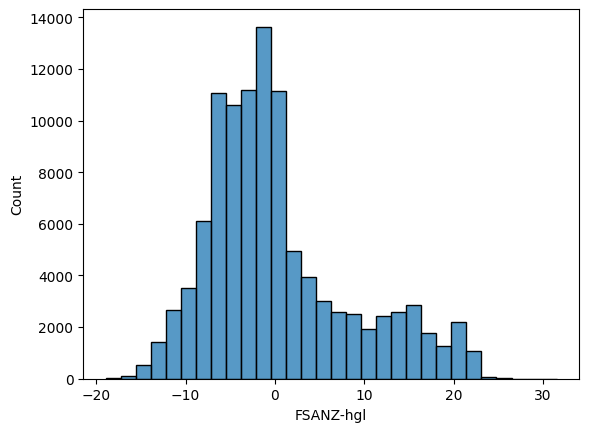

In [ ]:
sns.histplot(data=dfOFF2, x="FSANZ-hgl", bins=30)

In [ ]:
# save the predicted FSANZ values to OFF dataset
dfOFF2.to_csv("/Users/hgl/Dropbox/545_Group_Project/545_Group_project_shared/food_fact_withUnhealthScore.csv", index=False)
dfOFF2

,Unnamed: 0,code,product_name,brands,country,ingredients_text,additives,nutrition_grade_fr,energy,fat,...,fiber,proteins,salt,sodium,nutrition-score-fr,serving_size_numeric,serving_size_units,KCAL,NAsodium,FSANZ-hgl
0,67,32117,Tricolor Tortellini,Napoleon,United States,"Egg pasta (refined durum semolina wheat flour,...",0.0,c,1611.0,9.23,...,3.1,13.85,1.13284,0.446000,7.0,65.0,g,385.406699,446.000000,-4.089640
1,72,33060,10-Grain Pancake Mix,Bob's Red Mill,United States,"Wheat, rye, triticale, oat, corn, barley, soy ...",2.0,c,1297.0,1.72,...,6.9,13.79,2.75844,1.086000,9.0,58.0,g,310.287081,1086.000000,-8.053166
2,175,69601,Fresh Organic Carrots,Bunny-Luv,United States,Fresh organic carrots,0.0,a,159.0,0.00,...,2.6,1.28,0.19558,0.077000,-2.0,78.0,g,38.038278,77.000000,-9.774875
3,176,290616,Salade Cesar,Kirkland Signature,Canada,INGREDIENTS : LAITUE. VINAIGRETTE (HUILE DE CA...,0.0,c,1210.0,12.00,...,2.0,22.00,2.16000,0.850000,6.0,100.0,g,289.473684,850.000000,1.966481
4,182,1938067,Chaussons tressés aux pommes,Kirkland Signature,Canada,"Ingrédients : Pâte (farine, margarines d'huile...",5.0,c,1090.0,10.70,...,2.0,3.33,0.64700,0.255000,9.0,150.0,g,260.765550,255.000000,4.214868
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105180,355883,95656335,Chipotle Peppers In Adobo Sauce,La Costena,United States,"Chipotle peppers, water, vinegar, tomatoes, on...",0.0,c,280.0,0.00,...,10.0,0.00,3.21818,1.267000,6.0,30.0,g,66.985646,1267.000000,-13.900986
105181,355884,95659305,Dal Makhani,Truly Indian,United States,"Tomato, black gram, water, milk cream, cottons...",0.0,b,502.0,5.33,...,2.0,4.67,1.37160,0.540000,2.0,150.0,g,120.095694,540.000000,-6.750500
105182,355888,9577283844672,100% Pur Jus 4 agrumes,Cora,France,"Jus d'orange (dont pulpe 1,6%), jus de clément...",0.0,c,192.0,0.50,...,0.6,0.60,0.03000,0.011811,4.0,200.0,ml,45.933014,11.811024,-3.312844
105183,355985,9787461062105,Natural Cassava,Industria De Casabe Paul,United States,Cassava.,0.0,a,1477.0,0.00,...,4.7,1.18,0.03048,0.012000,-1.0,85.0,g,353.349282,12.000000,-3.944407
